# Ecosystems Group
OOI Data Labs Workshop - March 2019

**Working Title**: Ecosystem (Spatial) Structure 

**Short Description**: Exploration for the structure of an ocean ecosystem
through some of its biotic and abiotic factors
* Light (abiotic factor)- its attenuation in the ocean, and its role in photosynthesis
*	Chl A (biotic factor)-what ocean organisms photosynthesize, how the organisms abundance is estimated, and how abundance varies spatially,
*	O2 (abiotic factor)- understand how it’s connected to biological and physical processes


**Your Objective** (Challenge Question): 
* Light Q1: At which depth light starts to disappear? 
* Chlorophyll Q2: Compare the chlorophyll values between Papa , and Continental Array and describe the pattern. Explain why chlorophyll levels vary 
* O2 Q1: At which depths do chlorophyll and [O2] match at each array? Q2: Where don’t they match? 


In [0]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
! pip install netcdf4==1.5.0
import matplotlib.pyplot as plt
import pickle as pk
import gc
import pandas as pd
!pip install cmocean
import cmocean

    100% |████████████████████████████████| 3.9MB 6.2MB/s 
    100% |████████████████████████████████| 307kB 29.9MB/s 
    100% |████████████████████████████████| 225kB 11.8MB/s 


## Request Data from OOINet

Interested in Light, Chlorophyll and Oxygen data, potentially from [RS01SBPS](https://datareview.marine.rutgers.edu/sites/view/RS01SBPS).  
* Perhaps also Global Papa?  [GP02HYPM](https://datareview.marine.rutgers.edu/sites/view/GP02HYPM) - includes Chl and DO but no PAR.
* Another alternative is [CE04OSPS](https://datareview.marine.rutgers.edu/sites/view/CE04OSPS) or Coastal Pioneer.  Thee may have better temporal coverage, depending on what is needed.
* Could potentially use gliders, but probably not if a long-term single point timeseries is needed.  (While there are stationary profiling gliders, I don't think we have long records yet.)

See also these [processed FLORT datasets](https://github.com/ooi-data-review/2018-data-workshops/tree/master/biology/examples/extras/FLORT), which include data from the start of collection to spring 2018.
* oregon_slope_profiler RS01SBPS-SF01A-3A-FLORTD101
* axial_shallow_profiler RS03AXPS-SF03A-3A-FLORTD301
* oregon_offshore_profiler CE04OSPS-SF01B-3A-FLORTD104

In [0]:
def request_data(reference_designator,method,stream,start_date,end_date):
  site = reference_designator[:8]
  node = reference_designator[9:14]
  instrument = reference_designator[15:]
  
  # Create the request URL
  api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
  data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

  # All of the following are optional, but you should specify a date range
  params = {
    'beginDT':start_date,
    'endDT':end_date,
    'format':'application/netcdf',
    'include_provenance':'true',
    'include_annotations':'true'
  }

  # Make the data request
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  
  # Return just the THREDDS URL
  return data['allURLs'][0] 

In [0]:
API_USERNAME = ''
API_TOKEN = ''

In [0]:
# # CTD & DO Data
# request_data('RS01SBPS-SF01A-2A-CTDPFA102','streamed','ctdpf_sbe43_sample',
#              '2017-01-01T00:00:00.000Z','2019-01-01T00:00:00.000Z')

# # FLORT Data
# request_data('RS01SBPS-SF01A-3A-FLORTD101','streamed','flort_d_data_record',
#              '2017-01-01T00:00:00.000Z','2019-01-01T00:00:00.000Z')

# # PAR Data
# request_data('RS01SBPS-SF01A-3C-PARADA101','streamed','parad_sa_sample',
#              '2017-01-01T00:00:00.000Z','2019-01-01T00:00:00.000Z')

# # Others?
# RS01SBPS-SF01A-3D-SPKIRA101 streamed spkir_data_record  
# RS01SBPS-SF01A-3B-OPTAAD101 streamed optaa_sample
  


## Process the Datasets

In [0]:
# Resultant Dataset Directories
url_ctd = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190408T170230-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample/catalog.html'
url_flort = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190409T010828-RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record/catalog.html'
url_par = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190409T010844-RS01SBPS-SF01A-3C-PARADA101-streamed-parad_sa_sample/catalog.html'


In [0]:
# Function to grab the list of .nc files in the specified directory
def get_dataset_list(url,bad_inst=''):
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous files if necessary
  selected_datasets = []
  for d in datasets:
    if (bad_inst) and bad_inst in d:
      pass
    else:
      selected_datasets.append(d)
#   print(selected_datasets)
  return selected_datasets

In [0]:
# Function to make the output directory for the averaged pickle files
def make_dir(new_dir):
  if not os.path.isdir(new_dir):
    try:
      os.makedirs(new_dir)
    except OSError:
      if os.path.exists(new_dir):
        pass
      else:
        raise

### Process the CTD Profiler

In [0]:
ctd_list = get_dataset_list(url_ctd)
ctd_dir = 'ctd_minute_mean_data/'
make_dir(ctd_dir)

In [0]:
# Process the CTD Files
num = 0
for i in ctd_list:
    print('Downsampling file {} of {}'.format(str(num + 1), str(len(ctd_list))))
    ds = xr.open_dataset(i)
    ds = ds.swap_dims({'obs': 'time'})
    dnsample = pd.DataFrame()
    dnsample['practical_salinity'] = ds['practical_salinity'].to_pandas().resample('T').mean()
    dnsample['seawater_temperature'] = ds['seawater_temperature'].to_pandas().resample('T').mean()
    dnsample['seawater_pressure'] = ds['seawater_pressure'].to_pandas().resample('T').mean()
    dnsample['corrected_dissolved_oxygen'] = ds['corrected_dissolved_oxygen'].to_pandas().resample('T').mean()    
#     ds['seawater_temperature'].attrs.pop('units')
#     dnsample = dnsample.dropna()
    out = ctd_dir + i.split('/')[-1][:-3] + '_resampled' + '.pd'
    num = num +1
    with open(out, 'wb') as fh:
        pk.dump(dnsample,fh)
    gc.collect()
print('Complete!')

Downsampling file 1 of 7
Downsampling file 2 of 7
Downsampling file 3 of 7
Downsampling file 4 of 7
Downsampling file 5 of 7
Downsampling file 6 of 7
Downsampling file 7 of 7
Complete!


In [0]:
# Create a single file with all the pickled CTD data
ctd_data = pd.DataFrame()
for path, subdirs, files in os.walk(ctd_dir):
    for name in files:
        file_name = os.path.join(path, name)
        with open(file_name, 'rb') as f:
            pd_df = pk.load(f)
            ctd_data = ctd_data.append(pd_df)
with open('ctd_data.pd', 'wb') as f:
    pk.dump(ctd_data,f)

Text(0.5, 1.0, 'RS01SBPS-SF01A-2A-CTDPFA102')

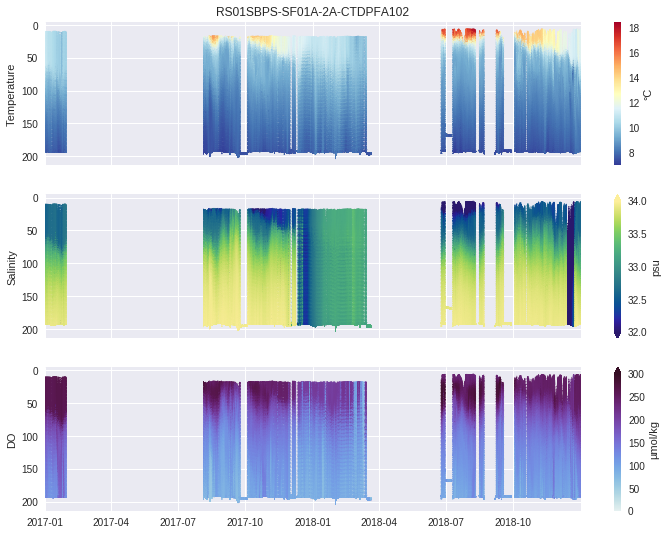

In [0]:
# Plot the data
fig, (ax1,ax2,ax3) = plt.subplots(3, sharex=True, sharey=True)
fig.set_size_inches(12, 9)

a1 = ax1.scatter(ctd_data.index, ctd_data.seawater_pressure, c=ctd_data.seawater_temperature, marker=".", s=1, cmap='RdYlBu_r')
a2 = ax2.scatter(ctd_data.index, ctd_data.seawater_pressure, c=ctd_data.practical_salinity, marker=".", s=1, vmin=32, vmax=34, cmap=cmocean.cm.haline)
a3 = ax3.scatter(ctd_data.index, ctd_data.seawater_pressure, c=ctd_data.corrected_dissolved_oxygen, marker=".", s=1, vmin=0, vmax=300,cmap=cmocean.cm.dense) 

cb1 = plt.colorbar(a1,ax=ax1)
cb2 = plt.colorbar(a2,ax=ax2,extend='both')
cb3 = plt.colorbar(a3,ax=ax3,extend='max')
cb1.set_label('°C')
cb2.set_label('psu')
cb3.set_label('µmol/kg')

ax1.set_ylabel("Temperature")
ax2.set_ylabel("Salinity")
ax3.set_ylabel("DO")

ax1.invert_yaxis()
ax1.set_xlim(min(ctd_data.index),max(ctd_data.index));

ax1.set_title('%s-%s-%s'%(ds.subsite,ds.node,ds.sensor));

# xlim_min = datetime.datetime(2015, 12, 1, 0, 0)
# xlim_max = datetime.datetime(2016, 12, 1, 0, 0)
# ax1.set_xlim(xlim_min,xlim_max)

# plt.savefig("test.png")


### Process the FLORT Profiler

In [0]:
flort_list = get_dataset_list(url_flort,'ctdpf')
flort_dir = 'flort_minute_mean_data/'
make_dir(flort_dir)
# flort_list

In [0]:
# Process the FLORT Files
num = 0
for i in flort_list:
    print('Downsampling file {} of {}'.format(str(num + 1), str(len(flort_list))))
    ds = xr.open_dataset(i)
    ds = ds.swap_dims({'obs': 'time'})
    dnsample = pd.DataFrame()
    dnsample['fluorometric_chlorophyll_a'] = ds['fluorometric_chlorophyll_a'].to_pandas().resample('T').mean()
    dnsample['int_ctd_pressure'] = ds['int_ctd_pressure'].to_pandas().resample('T').mean()
    dnsample['seawater_temperature'] = ds['seawater_temperature'].to_pandas().resample('T').mean()
    dnsample = dnsample.dropna()
    out = flort_dir + i.split('/')[-1][:-3] + '_resampled' + '.pd'
    num = num +1
    with open(out, 'wb') as fh:
        pk.dump(dnsample,fh)
    gc.collect()
print('Complete!')

Downsampling file 1 of 7
Downsampling file 2 of 7
Downsampling file 3 of 7
Downsampling file 4 of 7
Downsampling file 5 of 7
Downsampling file 6 of 7
Downsampling file 7 of 7
Complete!


In [0]:
# Create a single file with all the pickled data
flort_data = pd.DataFrame()
for path, subdirs, files in os.walk(flort_dir):
    for name in files:
        file_name = os.path.join(path, name)
        with open(file_name, 'rb') as f:
            pd_df = pk.load(f)
            flort_data = flort_data.append(pd_df)
with open('flort_data.pd', 'wb') as f:
    pk.dump(flort_data,f)

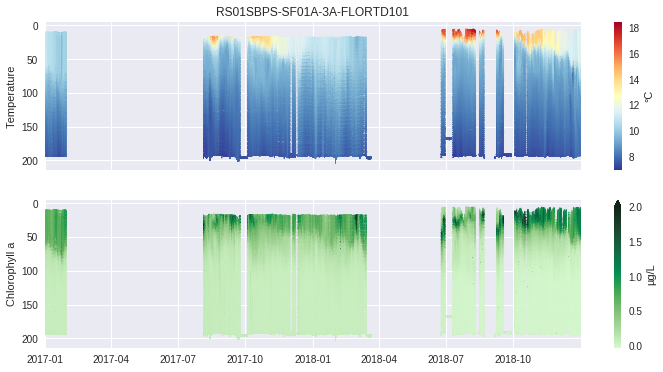

In [0]:
# Plot the data
fig, (ax1,ax2) = plt.subplots(2, sharex=True, sharey=True)
fig.set_size_inches(12, 6)

a1 = ax1.scatter(flort_data.index, flort_data.int_ctd_pressure, c=flort_data.seawater_temperature, marker=".", s=1, cmap='RdYlBu_r')
a2 = ax2.scatter(flort_data.index, flort_data.int_ctd_pressure, c=flort_data.fluorometric_chlorophyll_a, marker=".", s=1, vmax=2, cmap=cmocean.cm.algae)

cb1 = plt.colorbar(a1,ax=ax1)
cb2 = plt.colorbar(a2,ax=ax2, extend='max')
cb1.set_label('°C')
cb2.set_label('µg/L')

ax1.set_ylabel("Temperature")
ax2.set_ylabel("Chlorophyll a")

ax1.invert_yaxis()
ax1.set_xlim(min(ctd_data.index),max(ctd_data.index));

ax1.set_title('%s-%s-%s'%(ds.subsite,ds.node,ds.sensor));

# plt.savefig("test.png")

### Process the PAR Profiler

In [0]:
par_list = get_dataset_list(url_par,'ctdpf')
par_dir = 'par_minute_mean_data/'
make_dir(par_dir)

In [0]:
# Process the PAR Files
num = 0
for i in par_list:
    print('Downsampling file {} of {}'.format(str(num + 1), str(len(par_list))))
    ds = xr.open_dataset(i)
    ds = ds.swap_dims({'obs': 'time'})
    dnsample = pd.DataFrame()
    dnsample['par'] = ds['par'].to_pandas().resample('T').mean()
    dnsample['par_counts_output'] = ds['par_counts_output'].to_pandas().resample('T').mean()
    dnsample['int_ctd_pressure'] = ds['int_ctd_pressure'].to_pandas().resample('T').mean()
    dnsample = dnsample.dropna()
    out = par_dir + i.split('/')[-1][:-3] + '_resampled' + '.pd'
    num = num +1
    with open(out, 'wb') as fh:
        pk.dump(dnsample,fh)
    gc.collect()
print('Complete!')

Downsampling file 1 of 13
Downsampling file 2 of 13
Downsampling file 3 of 13
Downsampling file 4 of 13
Downsampling file 5 of 13
Downsampling file 6 of 13
Downsampling file 7 of 13
Downsampling file 8 of 13
Downsampling file 9 of 13
Downsampling file 10 of 13
Downsampling file 11 of 13
Downsampling file 12 of 13
Downsampling file 13 of 13
Complete!


In [0]:
# Create a single file with all the pickled data
par_data = pd.DataFrame()
for path, subdirs, files in os.walk(par_dir):
    for name in files:
        file_name = os.path.join(path, name)
        with open(file_name, 'rb') as f:
            pd_df = pk.load(f)
            par_data = par_data.append(pd_df)
with open('par_data.pd', 'wb') as f:
    pk.dump(par_data,f)

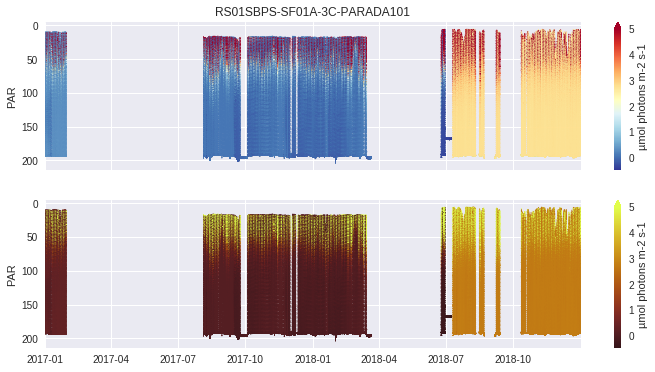

In [0]:
# Plot the data
fig, (ax1,ax2) = plt.subplots(2, sharex=True, sharey=True)
fig.set_size_inches(12, 6)

a1 = ax1.scatter(par_data.index, par_data.int_ctd_pressure, c=par_data.par_counts_output, marker=".", s=1, cmap='RdYlBu_r', vmax=5)
a2 = ax2.scatter(par_data.index, par_data.int_ctd_pressure, c=par_data.par_counts_output, marker=".", s=1, cmap=cmocean.cm.solar, vmax=5)

cb1 = plt.colorbar(a1,ax=ax1,extend='max')
cb2 = plt.colorbar(a2,ax=ax2,extend='max')
cb1.set_label('µmol photons m-2 s-1')
cb2.set_label('µmol photons m-2 s-1')

ax1.set_ylabel("PAR")
ax2.set_ylabel("PAR")

ax1.invert_yaxis()
ax1.set_xlim(min(par_data.index),max(par_data.index));

ax1.set_title('%s-%s-%s'%(ds.subsite,ds.node,ds.sensor));

# plt.savefig("test.png")

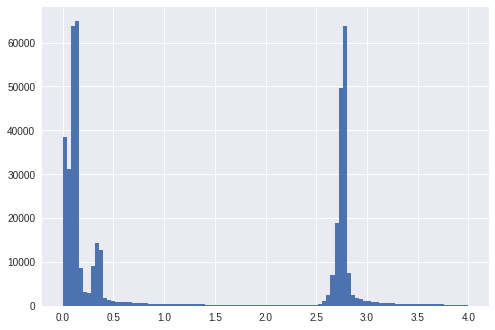

In [0]:
par_data.par_counts_output.hist(bins=100,range=(0,4))